# License

***

J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

from data_maker_and_getter import DataMakerAndGetter
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
from h2o.backend import H2OLocalServer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

pd.options.display.max_columns = 999 # enable display of all columns in notebook

In [2]:
%matplotlib inline

In [3]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_181"; Java(TM) SE Runtime Environment (build 1.8.0_181-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqpiyq3fk
  JVM stdout: /tmp/tmpqpiyq3fk/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpqpiyq3fk/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,00 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_patrickh_69q86f
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


#  Explore and prepare diabetes data

***

#### Import data and examine

In [4]:
# import CSV file
# set numeric categoricals to objects 

train = pd.read_csv('data/diabetes_train.csv')
train['discharge_disposition_id'] = train['discharge_disposition_id'].astype('object')
train['admission_type_id'] = train['admission_type_id'].astype('object')
train['admission_source_id'] = train['admission_source_id'].astype('object')

test = pd.read_csv('data/diabetes_test.csv')
test['discharge_disposition_id'] = test['discharge_disposition_id'].astype('object')
test['discharge_disposition_id'] = test['discharge_disposition_id'].astype('object')
test['admission_type_id'] = test['admission_type_id'].astype('object')
test['admission_source_id'] = test['admission_source_id'].astype('object')

In [5]:
train.head(n=10)

,id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,?,?,62,0,11,0,0,0,157,288,197,7,None,None,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
8,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,?,Family/GeneralPractice,60,0,15,0,1,0,428,250.43,250.6,8,None,None,Steady,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
9,42570,77586282,Caucasian,Male,[80-90),?,1,6,7,10,?,Family/GeneralPractice,55,1,31,0,0,0,428,411,427,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO


#### Examine high cardinality inputs

In [6]:
for col in train.select_dtypes(include=['object']):
    n_levels = len(train[col].unique())
    if n_levels > 20:
        print(col + ' levels: ', train[col].unique())
        print()

discharge_disposition_id levels:  [25 1 3 6 11 5 2 4 10 7 14 8 18 13 12 22 17 23 9 16 20 15 24 28 19 27]

medical_specialty levels:  ['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Nephrology' 'Orthopedics-Reconstructive'
 'Surgery-Cardiovascular/Thoracic' 'Pulmonology' 'Psychiatry'
 'Emergency/Trauma' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Otolaryngology'
 'Surgery-Colon&Rectal' 'Urology' 'Psychiatry-Child/Adolescent'
 'Endocrinology' 'Neurology' 'Anesthesiology-Pediatric'
 'Pediatrics-CriticalCare' 'Radiology' 'Pediatrics-Hematology-Oncology'
 'Psychology' 'Hematology/Oncology' 'Podiatry' 'Gynecology' 'Oncology'
 'Pediatrics-Neurology' 'Surgery-Plastic' 'Surgery-Thoracic'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabilitation' 'Pediatrics-Pulmonology'
 'Anesthesiology' 'Ophthalmology' 'InfectiousDiseas

 '750']

diag_3 levels:  ['?' 'V27' '403' '250' 'V45' '38' '486' '197' '250.6' '427' '996' '414'
 '714' '428' '582' '250.42' '998' '250.01' '618' '250.02' '305' '496'
 '599' '424' '553' '401' '794' '511' '276' '490' '562' '482' '250.7' '518'
 '411' '784' '491' '420' '8' '730' '131' '707' '41' '493' '529' '263'
 'E888' '425' '595' '560' '711' '296' '789' 'V43' '250.4' '654' 'V70'
 '625' '681' '250.51' 'V10' '280' '440' '244' '581' '569' '272' '250.43'
 '918' '54' '250.41' '788' '196' '461' '535' '584' '891' '332' '648'
 '250.03' '780' '182' '285' '278' '997' '413' '664' '201' 'V15' '292'
 '416' '473' '564' 'E932' '357' '348' 'E878' '437' '733' '525' '250.53'
 '397' '572' '805' '453' '331' '736' '250.8' '465' '533' '787' '349' '315'
 '658' '608' '786' '284' '382' '300' 'V42' '492' '438' '571' '536' '585'
 '644' '578' '682' 'V11' 'E885' '162' '198' '303' '412' '402' '396' 'V14'
 '570' '433' 'E934' '882' '288' '458' '785' '577' '729' '836' '799' '281'
 '616' '304' '250.83' '291' '512' '660

#### Utility function for simple binning of less common categorical levels

In [7]:
def bin_less_common_levels(train, test, col_name, in_list):
    
    """Places less common categorical levels into an 'Other' bin.
    
    :param train: Training set.
    :param test: Test set.
    :param col_name: Name of column in which to create 'Other' bin.
    :param in_list: List of levels NOT to be binned.
    
    """
    
    train.loc[~train[col_name].isin(in_list), col_name] = 'Other'
    test.loc[~test[col_name].isin(in_list), col_name] = 'Other'   
                                    
    print('Train levels after binning:\n', train[col_name].value_counts())
    print()
    print('Test levels after binning:\n', test[col_name].value_counts())
    

#### Bin medical_specialty

In [8]:
in_list = list(train['discharge_disposition_id'].value_counts()[:14].index)
bin_less_common_levels(train, test, 'discharge_disposition_id', in_list)

Train levels after binning:
 1        28733
3         6599
6         5414
18        2656
11        1329
2         1116
22        1076
5          741
25         606
4          475
7          307
Other      257
14         246
13         227
23         219
Name: discharge_disposition_id, dtype: int64

Test levels after binning:
 1        9985
3        2439
6        2126
22        398
2         344
11        313
13        136
14        119
7          95
5          93
4          62
23         49
Other      47
18          8
25          7
Name: discharge_disposition_id, dtype: int64


In [9]:
in_list = list(train['medical_specialty'].value_counts()[:10].index)
bin_less_common_levels(train, test, 'medical_specialty', in_list)

Train levels after binning:
 ?                             20893
InternalMedicine               8899
Other                          5162
Family/GeneralPractice         4370
Cardiology                     3037
Emergency/Trauma               2824
Surgery-General                1649
Orthopedics-Reconstructive      898
Nephrology                      883
Orthopedics                     839
Psychiatry                      547
Name: medical_specialty, dtype: int64

Test levels after binning:
 ?                             10841
Emergency/Trauma               1735
InternalMedicine               1013
Other                           974
Cardiology                      462
Family/GeneralPractice          407
Surgery-General                 404
Orthopedics                     234
Nephrology                       64
Psychiatry                       45
Orthopedics-Reconstructive       42
Name: medical_specialty, dtype: int64


#### Bin diag_1

In [10]:
in_list = list(train['diag_1'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_1', in_list)

Train levels after binning:
 Other    25298
414       3464
428       2924
786       2071
410       1992
486       1662
427       1256
434       1103
715       1103
780        974
682        936
996        909
276        895
38         799
491        791
250.8      709
599        689
584        677
V57        651
820        590
518        508
Name: diag_1, dtype: int64

Test levels after binning:
 Other    8061
414       993
428       849
410       557
427       536
786       527
715       480
486       477
491       411
434       337
38        335
682       332
584       319
780       315
599       289
996       287
276       281
250.8     269
518       240
820       195
V57       131
Name: diag_1, dtype: int64


#### Bin diag_2

In [11]:
in_list = list(train['diag_2'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_2', in_list)

Train levels after binning:
 Other     20558
250        3425
276        3399
428        3233
427        2564
401        2094
496        1681
599        1570
403        1373
411        1358
414        1248
250.02     1060
250.01      944
707         879
780         794
285         667
682         646
518         641
425         639
491         630
424         598
Name: diag_2, dtype: int64

Test levels after binning:
 Other     8346
250        966
276        961
428        750
427        643
401        607
599        555
414        503
285        350
518        311
707        302
411        285
496        283
250.02     255
491        217
682        210
425        199
780        171
403        164
424         88
250.01      55
Name: diag_2, dtype: int64


#### Bin diag_3

In [12]:
in_list = list(train['diag_3'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_3', in_list)

Train levels after binning:
 Other     20338
250        6212
401        4473
276        2516
428        2102
427        1906
414        1701
496        1336
403        1023
272        1019
?           985
599         927
585         725
V45         686
780         662
707         640
250.02      631
285         558
250.01      541
424         522
250.6       498
Name: diag_3, dtype: int64

Test levels after binning:
 Other     7415
250       1777
401       1331
276        868
414        612
428        603
427        545
585        412
272        388
403        347
599        319
496        270
285        228
250.02     220
780        207
707        191
V45        143
250.6      124
424        101
?          100
250.01      20
Name: diag_3, dtype: int64


#### Check binning results 

In [13]:
for col in train.select_dtypes(include=['object']):
    n_levels = len(train[col].unique())
    print(col, n_levels)

race 6
gender 3
age 10
weight 9
admission_type_id 8
discharge_disposition_id 15
admission_source_id 14
payer_code 17
medical_specialty 11
diag_1 21
diag_2 21
diag_3 21
max_glu_serum 4
A1Cresult 4
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 1
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 4
miglitol 4
troglitazone 2
tolazamide 2
examide 1
citoglipton 1
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 1
metformin-rosiglitazone 1
metformin-pioglitazone 1
change 2
diabetesMed 2
readmitted 2


#### Define target and variables to be dropped from the analysis

In [14]:
drops = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
target = 'readmitted'
encodes = list(set(train.select_dtypes(include=['object']).columns) - set(drops + [target]))

#### Dummy-encode categorical variables

In [15]:
train = pd.concat([train.drop(encodes, axis=1),
                   pd.get_dummies(train[encodes])],
                   axis = 1)

test = pd.concat([test.drop(encodes, axis=1),
                  pd.get_dummies(test[encodes])],
                   axis = 1)

#### Ensure train and test have the same input variables after encoding

In [16]:
in_train_not_test = list(set(train.columns)-set(test.columns))
train.drop(in_train_not_test, axis=1, inplace=True)

in_test_not_train = list(set(test.columns)-set(train.columns))
test.drop(in_test_not_train, axis=1, inplace=True)

In [17]:
for name in train.columns:
    
    train.rename(columns={name: name.replace('_?', '_q')}, inplace=True)
    train.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)
    
    test.rename(columns={name: name.replace('_?', '_q')}, inplace=True)
    test.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)
    

In [18]:
print('All train and test columns match:', all(train.columns == test.columns))
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

All train and test columns match: True
Train set shape: (50001, 233)
Test set shape: (16221, 233)


#### Assign modeling roles

In [19]:
# assign target and inputs for GBM
y = 'readmitted'
drops = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 
         'metformin_pioglitazone']
X = [name for name in train.columns if name not in [target] + drops + ['id', 'patient_nbr']]
print('y =', y)
print('X =', X)

y = readmitted
X = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'nateglinide_Down', 'nateglinide_No', 'nateglinide_Steady', 'nateglinide_Up', 'glipizide_metformin_No', 'glimepiride_Down', 'glimepiride_No', 'glimepiride_Steady', 'glimepiride_Up', 'age_0_10_', 'age_10_20_', 'age_20_30_', 'age_30_40_', 'age_40_50_', 'age_50_60_', 'age_60_70_', 'age_70_80_', 'age_80_90_', 'age_90_100_', 'discharge_disposition_id_1', 'discharge_disposition_id_2', 'discharge_disposition_id_3', 'discharge_disposition_id_4', 'discharge_disposition_id_5', 'discharge_disposition_id_6', 'discharge_disposition_id_7', 'discharge_disposition_id_11', 'discharge_disposition_id_13', 'discharge_disposition_id_14', 'discharge_disposition_id_18', 'discharge_disposition_id_22', 'discharge_disposition_id_23', 'discharge_disposition_id_25', 'discharge_disposition_id_Other', 'change_Ch', 'change_No', 'metformin_

#### Ensure Pandas treats all target variable and all input variables as numeric

In [20]:
train[X] = train[X].apply(pd.to_numeric, errors='coerce', axis=1)
test[X] = test[X].apply(pd.to_numeric, errors='coerce', axis=1)

In [21]:
train.loc[train[y] == 'NO', y] = '0'
train.loc[train[y] != '0', y] = '1'
train[y] = train[y].apply(pd.to_numeric)

test.loc[test[y] == 'NO', y] = '0'
test.loc[test[y] != '0', y] = '1'
test[y] = test[y].apply(pd.to_numeric)

In [22]:
train[X + [y]].head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_metformin_No,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,change_Ch,change_No,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,tolbutamide_No,tolbutamide_Steady,chlorpropamide_No,chlorpropamide_Steady,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,tolazamide_No,gender_Female,gender_Male,gender_Unknown_Invalid,acarbose_No,acarbose_Steady,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glyburide_metformin_No,glyburide_metformin_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,miglitol_Down,miglitol_No,miglitol_Steady,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,troglitazone_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,readmitted
0,1,41,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0

In [23]:
test[X + [y]].head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_metformin_No,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,change_Ch,change_No,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,tolbutamide_No,tolbutamide_Steady,chlorpropamide_No,chlorpropamide_Steady,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,tolazamide_No,gender_Female,gender_Male,gender_Unknown_Invalid,acarbose_No,acarbose_Steady,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glyburide_metformin_No,glyburide_metformin_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,miglitol_Down,miglitol_No,miglitol_Steady,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,troglitazone_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,readmitted
0,1,50,6,25,0,0,0,9,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,

#### Calculate Pearson correlation

In [24]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(train[X + [y]].corr()[y]).iloc[:-1]

,readmitted
time_in_hospital,0.068106
num_lab_procedures,0.032412
num_procedures,-0.029204
num_medications,0.055739
number_outpatient,0.055808
number_emergency,0.121695
number_inpatient,0.268620
number_diagnoses,0.103977
nateglinide_Down,-0.002938
nateglinide_No,-0.001807


#### Create tuple of monotonicity constraints from Pearson correlation values

In [25]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(train[X + [y]].corr()[y].values[:-1])])
mono_constraints

(1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -

# Train XGBoost with monotonicity constraints

In [26]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

In [27]:
# determine mean y value in training
y_mean = train[y].mean()

params = {
     'base_score': y_mean,
     'booster': 'gbtree',
     'colsample_bytree': 0.5,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 18,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.001,
     'reg_lambda': 0.001,
     'monotone_constraints': mono_constraints,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.9}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]

model = xgb.train(
                params, 
                dtrain, 
                5000,
                early_stopping_rounds=100,
                evals=watchlist, 
                verbose_eval=True)


[0]	train-auc:0.623376	eval-auc:0.635479
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[1]	train-auc:0.69751	eval-auc:0.69248
[2]	train-auc:0.690471	eval-auc:0.687981
[3]	train-auc:0.698384	eval-auc:0.693479
[4]	train-auc:0.703323	eval-auc:0.697177
[5]	train-auc:0.707445	eval-auc:0.700544
[6]	train-auc:0.714589	eval-auc:0.707804
[7]	train-auc:0.715804	eval-auc:0.708231
[8]	train-auc:0.715159	eval-auc:0.706791
[9]	train-auc:0.714301	eval-auc:0.705749
[10]	train-auc:0.713384	eval-auc:0.704911
[11]	train-auc:0.713739	eval-auc:0.705545
[12]	train-auc:0.713289	eval-auc:0.705331
[13]	train-auc:0.712807	eval-auc:0.705112
[14]	train-auc:0.713022	eval-auc:0.704874
[15]	train-auc:0.712439	eval-auc:0.704415
[16]	train-auc:0.713146	eval-auc:0.705414
[17]	train-auc:0.712881	eval-auc:0.704991
[18]	train-auc:0.71307	eval-auc:0.704953
[19]	train-auc:0.713601	eval-auc:0.705536
[20]	train-auc:0.713185	eval-au

[191]	train-auc:0.726443	eval-auc:0.715222
[192]	train-auc:0.726504	eval-auc:0.715256
[193]	train-auc:0.726716	eval-auc:0.715374
[194]	train-auc:0.726701	eval-auc:0.715302
[195]	train-auc:0.72693	eval-auc:0.715522
[196]	train-auc:0.727042	eval-auc:0.715647
[197]	train-auc:0.727122	eval-auc:0.715804
[198]	train-auc:0.727321	eval-auc:0.715974
[199]	train-auc:0.727403	eval-auc:0.716031
[200]	train-auc:0.72737	eval-auc:0.716002
[201]	train-auc:0.727621	eval-auc:0.716125
[202]	train-auc:0.727814	eval-auc:0.716302
[203]	train-auc:0.727874	eval-auc:0.716343
[204]	train-auc:0.727927	eval-auc:0.716342
[205]	train-auc:0.727908	eval-auc:0.716291
[206]	train-auc:0.727955	eval-auc:0.716402
[207]	train-auc:0.728022	eval-auc:0.716452
[208]	train-auc:0.727963	eval-auc:0.716397
[209]	train-auc:0.728058	eval-auc:0.716435
[210]	train-auc:0.728096	eval-auc:0.716456
[211]	train-auc:0.728165	eval-auc:0.716475
[212]	train-auc:0.728337	eval-auc:0.716622
[213]	train-auc:0.728479	eval-auc:0.716703
[214]	train-a

[383]	train-auc:0.738211	eval-auc:0.72224
[384]	train-auc:0.738272	eval-auc:0.722257
[385]	train-auc:0.738321	eval-auc:0.722258
[386]	train-auc:0.738383	eval-auc:0.722303
[387]	train-auc:0.738448	eval-auc:0.722337
[388]	train-auc:0.738505	eval-auc:0.722383
[389]	train-auc:0.738571	eval-auc:0.722416
[390]	train-auc:0.738619	eval-auc:0.722436
[391]	train-auc:0.738644	eval-auc:0.722423
[392]	train-auc:0.738697	eval-auc:0.722484
[393]	train-auc:0.738758	eval-auc:0.72251
[394]	train-auc:0.738763	eval-auc:0.722519
[395]	train-auc:0.738803	eval-auc:0.722518
[396]	train-auc:0.738827	eval-auc:0.722513
[397]	train-auc:0.738879	eval-auc:0.722521
[398]	train-auc:0.738942	eval-auc:0.722563
[399]	train-auc:0.738978	eval-auc:0.722616
[400]	train-auc:0.739025	eval-auc:0.722644
[401]	train-auc:0.739071	eval-auc:0.722682
[402]	train-auc:0.739074	eval-auc:0.722693
[403]	train-auc:0.739123	eval-auc:0.722697
[404]	train-auc:0.739177	eval-auc:0.722717
[405]	train-auc:0.739226	eval-auc:0.722773
[406]	train-a

[575]	train-auc:0.745798	eval-auc:0.725595
[576]	train-auc:0.745835	eval-auc:0.725587
[577]	train-auc:0.745867	eval-auc:0.725607
[578]	train-auc:0.745899	eval-auc:0.725608
[579]	train-auc:0.745931	eval-auc:0.72561
[580]	train-auc:0.745966	eval-auc:0.725622
[581]	train-auc:0.746002	eval-auc:0.725633
[582]	train-auc:0.746026	eval-auc:0.725643
[583]	train-auc:0.746055	eval-auc:0.725653
[584]	train-auc:0.746075	eval-auc:0.725662
[585]	train-auc:0.746115	eval-auc:0.725679
[586]	train-auc:0.746152	eval-auc:0.725677
[587]	train-auc:0.746178	eval-auc:0.72569
[588]	train-auc:0.746232	eval-auc:0.725695
[589]	train-auc:0.74628	eval-auc:0.725707
[590]	train-auc:0.746317	eval-auc:0.725722
[591]	train-auc:0.746346	eval-auc:0.725736
[592]	train-auc:0.746376	eval-auc:0.725754
[593]	train-auc:0.746398	eval-auc:0.725761
[594]	train-auc:0.746424	eval-auc:0.725777
[595]	train-auc:0.746448	eval-auc:0.725777
[596]	train-auc:0.746474	eval-auc:0.725795
[597]	train-auc:0.746529	eval-auc:0.725792
[598]	train-au

[767]	train-auc:0.750801	eval-auc:0.726899
[768]	train-auc:0.75083	eval-auc:0.726914
[769]	train-auc:0.750859	eval-auc:0.726905
[770]	train-auc:0.750872	eval-auc:0.726918
[771]	train-auc:0.750899	eval-auc:0.726934
[772]	train-auc:0.750916	eval-auc:0.726925
[773]	train-auc:0.750927	eval-auc:0.726934
[774]	train-auc:0.750948	eval-auc:0.726938
[775]	train-auc:0.750965	eval-auc:0.726943
[776]	train-auc:0.750995	eval-auc:0.72694
[777]	train-auc:0.751027	eval-auc:0.726936
[778]	train-auc:0.751045	eval-auc:0.726939
[779]	train-auc:0.751068	eval-auc:0.726938
[780]	train-auc:0.751096	eval-auc:0.726939
[781]	train-auc:0.751117	eval-auc:0.726949
[782]	train-auc:0.751136	eval-auc:0.726943
[783]	train-auc:0.751159	eval-auc:0.726949
[784]	train-auc:0.751182	eval-auc:0.726952
[785]	train-auc:0.751208	eval-auc:0.726968
[786]	train-auc:0.751221	eval-auc:0.72698
[787]	train-auc:0.751247	eval-auc:0.726991
[788]	train-auc:0.751269	eval-auc:0.726995
[789]	train-auc:0.751283	eval-auc:0.726994
[790]	train-au

[959]	train-auc:0.754416	eval-auc:0.727762
[960]	train-auc:0.75443	eval-auc:0.727766
[961]	train-auc:0.754451	eval-auc:0.727763
[962]	train-auc:0.754468	eval-auc:0.727761
[963]	train-auc:0.754482	eval-auc:0.727773
[964]	train-auc:0.75449	eval-auc:0.727779
[965]	train-auc:0.754509	eval-auc:0.727792
[966]	train-auc:0.754527	eval-auc:0.727786
[967]	train-auc:0.754546	eval-auc:0.727789
[968]	train-auc:0.754564	eval-auc:0.727791
[969]	train-auc:0.754587	eval-auc:0.7278
[970]	train-auc:0.7546	eval-auc:0.727805
[971]	train-auc:0.754614	eval-auc:0.727812
[972]	train-auc:0.754626	eval-auc:0.727812
[973]	train-auc:0.754642	eval-auc:0.727813
[974]	train-auc:0.754658	eval-auc:0.727806
[975]	train-auc:0.754676	eval-auc:0.727809
[976]	train-auc:0.754689	eval-auc:0.727817
[977]	train-auc:0.754705	eval-auc:0.727819
[978]	train-auc:0.754717	eval-auc:0.727827
[979]	train-auc:0.754737	eval-auc:0.727839
[980]	train-auc:0.754758	eval-auc:0.727841
[981]	train-auc:0.754771	eval-auc:0.727849
[982]	train-auc:0

[1148]	train-auc:0.757238	eval-auc:0.728376
[1149]	train-auc:0.757248	eval-auc:0.728388
[1150]	train-auc:0.757257	eval-auc:0.728387
[1151]	train-auc:0.757275	eval-auc:0.728388
[1152]	train-auc:0.757303	eval-auc:0.728381
[1153]	train-auc:0.75731	eval-auc:0.728388
[1154]	train-auc:0.75732	eval-auc:0.728387
[1155]	train-auc:0.757337	eval-auc:0.728392
[1156]	train-auc:0.757348	eval-auc:0.728394
[1157]	train-auc:0.757358	eval-auc:0.728393
[1158]	train-auc:0.75737	eval-auc:0.728384
[1159]	train-auc:0.757379	eval-auc:0.728392
[1160]	train-auc:0.757395	eval-auc:0.728399
[1161]	train-auc:0.757405	eval-auc:0.728396
[1162]	train-auc:0.757417	eval-auc:0.728398
[1163]	train-auc:0.75744	eval-auc:0.728404
[1164]	train-auc:0.757448	eval-auc:0.728416
[1165]	train-auc:0.757458	eval-auc:0.728429
[1166]	train-auc:0.757474	eval-auc:0.728433
[1167]	train-auc:0.757487	eval-auc:0.728437
[1168]	train-auc:0.757501	eval-auc:0.72844
[1169]	train-auc:0.757512	eval-auc:0.728441
[1170]	train-auc:0.757526	eval-auc:0.

[1336]	train-auc:0.759533	eval-auc:0.728678
[1337]	train-auc:0.759545	eval-auc:0.728674
[1338]	train-auc:0.759556	eval-auc:0.728672
[1339]	train-auc:0.759565	eval-auc:0.728674
[1340]	train-auc:0.759577	eval-auc:0.728682
[1341]	train-auc:0.75959	eval-auc:0.728687
[1342]	train-auc:0.759601	eval-auc:0.7287
[1343]	train-auc:0.759612	eval-auc:0.728696
[1344]	train-auc:0.759618	eval-auc:0.728697
[1345]	train-auc:0.759625	eval-auc:0.728689
[1346]	train-auc:0.759635	eval-auc:0.728693
[1347]	train-auc:0.759647	eval-auc:0.728683
[1348]	train-auc:0.759658	eval-auc:0.728674
[1349]	train-auc:0.759669	eval-auc:0.728672
[1350]	train-auc:0.759698	eval-auc:0.728678
[1351]	train-auc:0.759709	eval-auc:0.728681
[1352]	train-auc:0.759719	eval-auc:0.728689
[1353]	train-auc:0.75973	eval-auc:0.728697
[1354]	train-auc:0.759743	eval-auc:0.728702
[1355]	train-auc:0.759749	eval-auc:0.728703
[1356]	train-auc:0.759754	eval-auc:0.728695
[1357]	train-auc:0.759763	eval-auc:0.7287
[1358]	train-auc:0.759773	eval-auc:0.7

[1524]	train-auc:0.761357	eval-auc:0.729021
[1525]	train-auc:0.761369	eval-auc:0.729018
[1526]	train-auc:0.76138	eval-auc:0.729024
[1527]	train-auc:0.761391	eval-auc:0.72902
[1528]	train-auc:0.761395	eval-auc:0.729018
[1529]	train-auc:0.761404	eval-auc:0.729024
[1530]	train-auc:0.761414	eval-auc:0.729025
[1531]	train-auc:0.761427	eval-auc:0.729029
[1532]	train-auc:0.761433	eval-auc:0.729032
[1533]	train-auc:0.761441	eval-auc:0.729035
[1534]	train-auc:0.761454	eval-auc:0.729029
[1535]	train-auc:0.761464	eval-auc:0.729027
[1536]	train-auc:0.761471	eval-auc:0.729028
[1537]	train-auc:0.76148	eval-auc:0.72903
[1538]	train-auc:0.761487	eval-auc:0.729024
[1539]	train-auc:0.76149	eval-auc:0.729027
[1540]	train-auc:0.761497	eval-auc:0.729027
[1541]	train-auc:0.761503	eval-auc:0.729032
[1542]	train-auc:0.761514	eval-auc:0.729031
[1543]	train-auc:0.761519	eval-auc:0.729028
[1544]	train-auc:0.761528	eval-auc:0.729032
[1545]	train-auc:0.761536	eval-auc:0.72904
[1546]	train-auc:0.761542	eval-auc:0.7

[1712]	train-auc:0.762994	eval-auc:0.729108
[1713]	train-auc:0.763	eval-auc:0.729111
[1714]	train-auc:0.763009	eval-auc:0.729121
[1715]	train-auc:0.763015	eval-auc:0.729125
[1716]	train-auc:0.763023	eval-auc:0.729126
[1717]	train-auc:0.76303	eval-auc:0.729123
[1718]	train-auc:0.763034	eval-auc:0.729126
[1719]	train-auc:0.763039	eval-auc:0.729122
[1720]	train-auc:0.763054	eval-auc:0.729126
[1721]	train-auc:0.763059	eval-auc:0.729132
[1722]	train-auc:0.763066	eval-auc:0.729131
[1723]	train-auc:0.763073	eval-auc:0.729127
[1724]	train-auc:0.763082	eval-auc:0.729136
[1725]	train-auc:0.763089	eval-auc:0.729133
[1726]	train-auc:0.763095	eval-auc:0.729137
[1727]	train-auc:0.763102	eval-auc:0.729136
[1728]	train-auc:0.763111	eval-auc:0.729142
[1729]	train-auc:0.763125	eval-auc:0.729151
[1730]	train-auc:0.763128	eval-auc:0.729157
[1731]	train-auc:0.763135	eval-auc:0.729159
[1732]	train-auc:0.763142	eval-auc:0.729158
[1733]	train-auc:0.763146	eval-auc:0.729157
[1734]	train-auc:0.763156	eval-auc:0

[1900]	train-auc:0.764405	eval-auc:0.729283
[1901]	train-auc:0.764409	eval-auc:0.729285
[1902]	train-auc:0.764413	eval-auc:0.729283
[1903]	train-auc:0.764425	eval-auc:0.729273
[1904]	train-auc:0.764432	eval-auc:0.72927
[1905]	train-auc:0.764436	eval-auc:0.729277
[1906]	train-auc:0.764442	eval-auc:0.729267
[1907]	train-auc:0.764447	eval-auc:0.729264
[1908]	train-auc:0.764455	eval-auc:0.729261
[1909]	train-auc:0.764464	eval-auc:0.729262
[1910]	train-auc:0.764467	eval-auc:0.729259
[1911]	train-auc:0.764473	eval-auc:0.729259
[1912]	train-auc:0.764479	eval-auc:0.729262
[1913]	train-auc:0.764486	eval-auc:0.729261
[1914]	train-auc:0.764493	eval-auc:0.729261
[1915]	train-auc:0.764496	eval-auc:0.729261
[1916]	train-auc:0.764503	eval-auc:0.729262
[1917]	train-auc:0.764512	eval-auc:0.729262
[1918]	train-auc:0.764518	eval-auc:0.729262
[1919]	train-auc:0.764533	eval-auc:0.72926
[1920]	train-auc:0.76454	eval-auc:0.729262
[1921]	train-auc:0.764545	eval-auc:0.729275
[1922]	train-auc:0.764551	eval-auc:

[2088]	train-auc:0.765621	eval-auc:0.729304
[2089]	train-auc:0.765627	eval-auc:0.729306
[2090]	train-auc:0.765634	eval-auc:0.729313
[2091]	train-auc:0.765636	eval-auc:0.729317
[2092]	train-auc:0.765643	eval-auc:0.72932
[2093]	train-auc:0.765649	eval-auc:0.729316
[2094]	train-auc:0.765651	eval-auc:0.729322
[2095]	train-auc:0.765658	eval-auc:0.72932
[2096]	train-auc:0.765667	eval-auc:0.729322
[2097]	train-auc:0.765672	eval-auc:0.729319
[2098]	train-auc:0.765678	eval-auc:0.729322
[2099]	train-auc:0.765683	eval-auc:0.729331
[2100]	train-auc:0.76569	eval-auc:0.729332
[2101]	train-auc:0.765694	eval-auc:0.729336
[2102]	train-auc:0.765702	eval-auc:0.729337
[2103]	train-auc:0.76571	eval-auc:0.729331
[2104]	train-auc:0.765716	eval-auc:0.72933
[2105]	train-auc:0.765725	eval-auc:0.729327
[2106]	train-auc:0.765731	eval-auc:0.729304
[2107]	train-auc:0.765737	eval-auc:0.729307
[2108]	train-auc:0.765744	eval-auc:0.729305
[2109]	train-auc:0.765748	eval-auc:0.729304
[2110]	train-auc:0.765753	eval-auc:0.

# Global Variable Importance 

***

#### Shapley variable importance

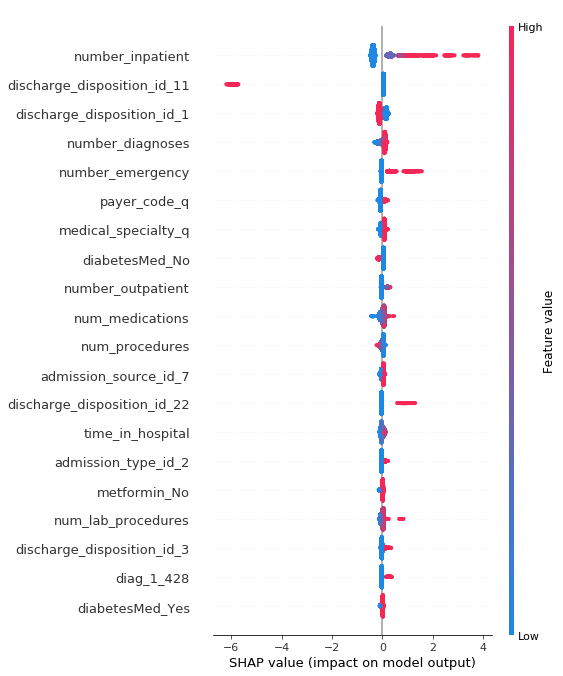

In [28]:
# ~ 80 mins
shap_values = model.predict(dtest, pred_contribs=True)
shap.summary_plot(shap_values, test[X])

#### Function for calculating partial dependence

In [29]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [30]:
# ~ 15 mins
par_dep_number_inpatient = par_dep('number_inpatient', test[X], model)
par_dep_discharge_disposition_id_11 = par_dep('discharge_disposition_id_11', test[X], model)
par_dep_discharge_disposition_id_1 = par_dep('discharge_disposition_id_1', test[X], model)
par_dep_number_diagnoses = par_dep('number_diagnoses', test[X], model)
par_dep_number_emergency = par_dep('number_emergency', test[X], model)

#### Add row ID column to test set for later joins

In [31]:
test['ID'] = np.arange(test.shape[0])

#### Bind XGBoost predictions to training data

In [32]:
xgb_preds = pd.DataFrame(model.predict(dtest))

In [33]:
test.reset_index(inplace=True)
test.drop(['index'], inplace=True, axis=1)

In [34]:
decile_frame = pd.concat([test, xgb_preds], axis=1)
decile_frame = decile_frame.rename(columns={0: 'predict'})
decile_hframe = h2o.H2OFrame(decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
decile_frame.head()

,id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,acetohexamide,examide,citoglipton,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmitted,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_metformin_No,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,change_Ch,change_No,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,tolbutamide_No,tolbutamide_Steady,chlorpropamide_No,chlorpropamide_Steady,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,tolazamide_No,gender_Female,gender_Male,gender_Unknown_Invalid,acarbose_No,acarbose_Steady,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glyburide_metformin_No,glyburide_metformin_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,miglitol_Down,miglitol_No,miglitol_Steady,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,troglitazone_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,ID,predict
0,240277404,34289775,1,50,6,25,0,0,0,9,No,No,No,No,No,No,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0

#### Find percentiles of XGBoost predictions

In [36]:
ds_ = DataMakerAndGetter()
percentile_dict = ds_.get_percentile_dict('predict', 'ID', decile_hframe)

In [37]:
percentile_dict

{0: 10943,
 10: 16202,
 20: 13185,
 30: 8039,
 40: 15493,
 50: 14401,
 60: 3155,
 70: 7673,
 80: 15617,
 90: 5538,
 99: 3354}

#### Calculate ICE curve values

In [38]:
# retreive bins from original partial dependence calculation
bins_number_inpatient = list(par_dep_number_inpatient['number_inpatient'])
bins_discharge_disposition_id_11 = list(par_dep_discharge_disposition_id_11['discharge_disposition_id_11'])
bins_discharge_disposition_id_1 = list(par_dep_discharge_disposition_id_1['discharge_disposition_id_1'])
bins_number_diagnoses = list(par_dep_number_diagnoses['number_diagnoses'])
bins_number_emergency = list(par_dep_number_emergency['number_emergency'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves across percentiles 
    par_dep_number_inpatient[col_name] = par_dep('number_inpatient', 
                                                 test[test['ID'] == int(percentile_dict[i])][X], 
                                                 model, 
                                                 bins=bins_number_inpatient)['partial_dependence']

    par_dep_discharge_disposition_id_11[col_name] = par_dep('discharge_disposition_id_11', 
                                                            test[test['ID'] == int(percentile_dict[i])][X], 
                                                            model, 
                                                            bins=bins_discharge_disposition_id_11)['partial_dependence']

    
    par_dep_discharge_disposition_id_1[col_name] = par_dep('discharge_disposition_id_1', 
                                                           test[test['ID'] == int(percentile_dict[i])][X], 
                                                           model, 
                                                           bins=bins_discharge_disposition_id_1)['partial_dependence']
    
    par_dep_number_diagnoses[col_name] = par_dep('number_diagnoses', 
                                                 test[test['ID'] == int(percentile_dict[i])][X], 
                                                 model, 
                                                 bins=bins_number_diagnoses)['partial_dependence']
    
    par_dep_number_emergency[col_name] = par_dep('number_emergency', 
                                                 test[test['ID'] == int(percentile_dict[i])][X], 
                                                 model, 
                                                 bins=bins_number_emergency)['partial_dependence']


#### Plot partial dependence and ICE

In [39]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


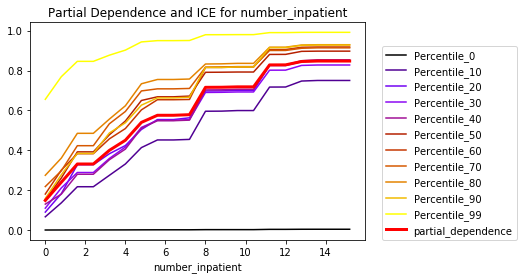

In [40]:
plot_par_dep_ICE('number_inpatient', par_dep_number_inpatient)

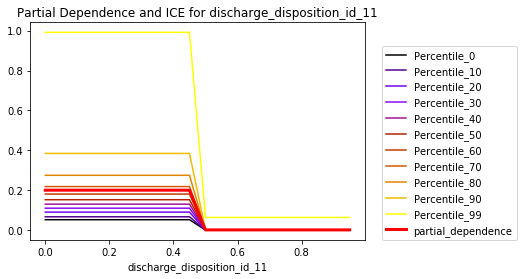

In [41]:
plot_par_dep_ICE('discharge_disposition_id_11', par_dep_discharge_disposition_id_11)

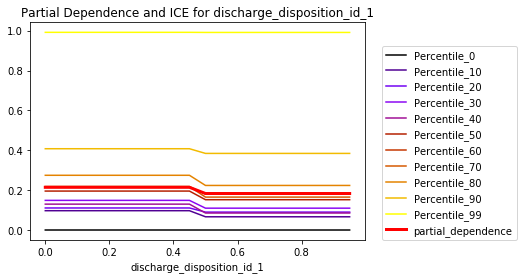

In [42]:
plot_par_dep_ICE('discharge_disposition_id_1', par_dep_discharge_disposition_id_1) # why is the bottom line flat?

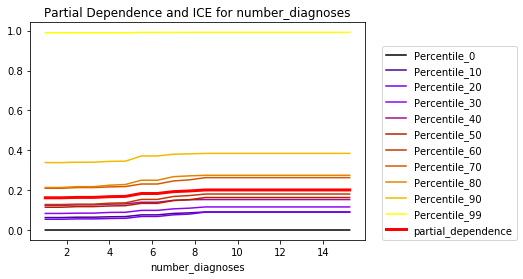

In [43]:
plot_par_dep_ICE('number_diagnoses', par_dep_number_diagnoses)

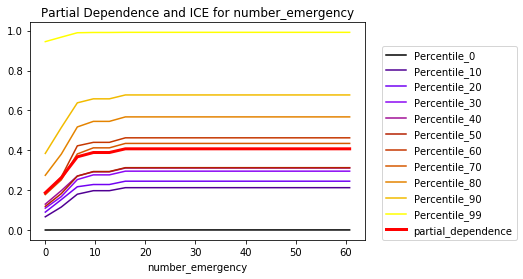

In [44]:
plot_par_dep_ICE('number_emergency', par_dep_number_emergency)

#### Train single h2o decision tree

In [45]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=4,       # shallow trees are easier to understand
                                     nfolds=3,          # check stability
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/diabetes_use_case/dt_surrogate_mojo.zip


In [46]:
surrogate.cross_validation_metrics_summary()

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0530132,0.0006745,0.0538814,0.0534733,0.0516850
mean_residual_deviance,0.0057696,0.0000227,0.0058118,0.0057630,0.0057340
mse,0.0057696,0.0000227,0.0058118,0.0057630,0.0057340
r2,0.7333978,0.0046604,0.7282659,0.7292254,0.7427021
residual_deviance,0.0057696,0.0000227,0.0058118,0.0057630,0.0057340
rmse,0.0759576,0.0001494,0.0762353,0.0759144,0.0757232
rmsle,0.0597212,0.0001771,0.0598048,0.0599775,0.0593812


#### Create GraphViz dot file

In [47]:
# title for plot
title = 'Diabetes Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/diabetes_use_case/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Diabetes Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [48]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


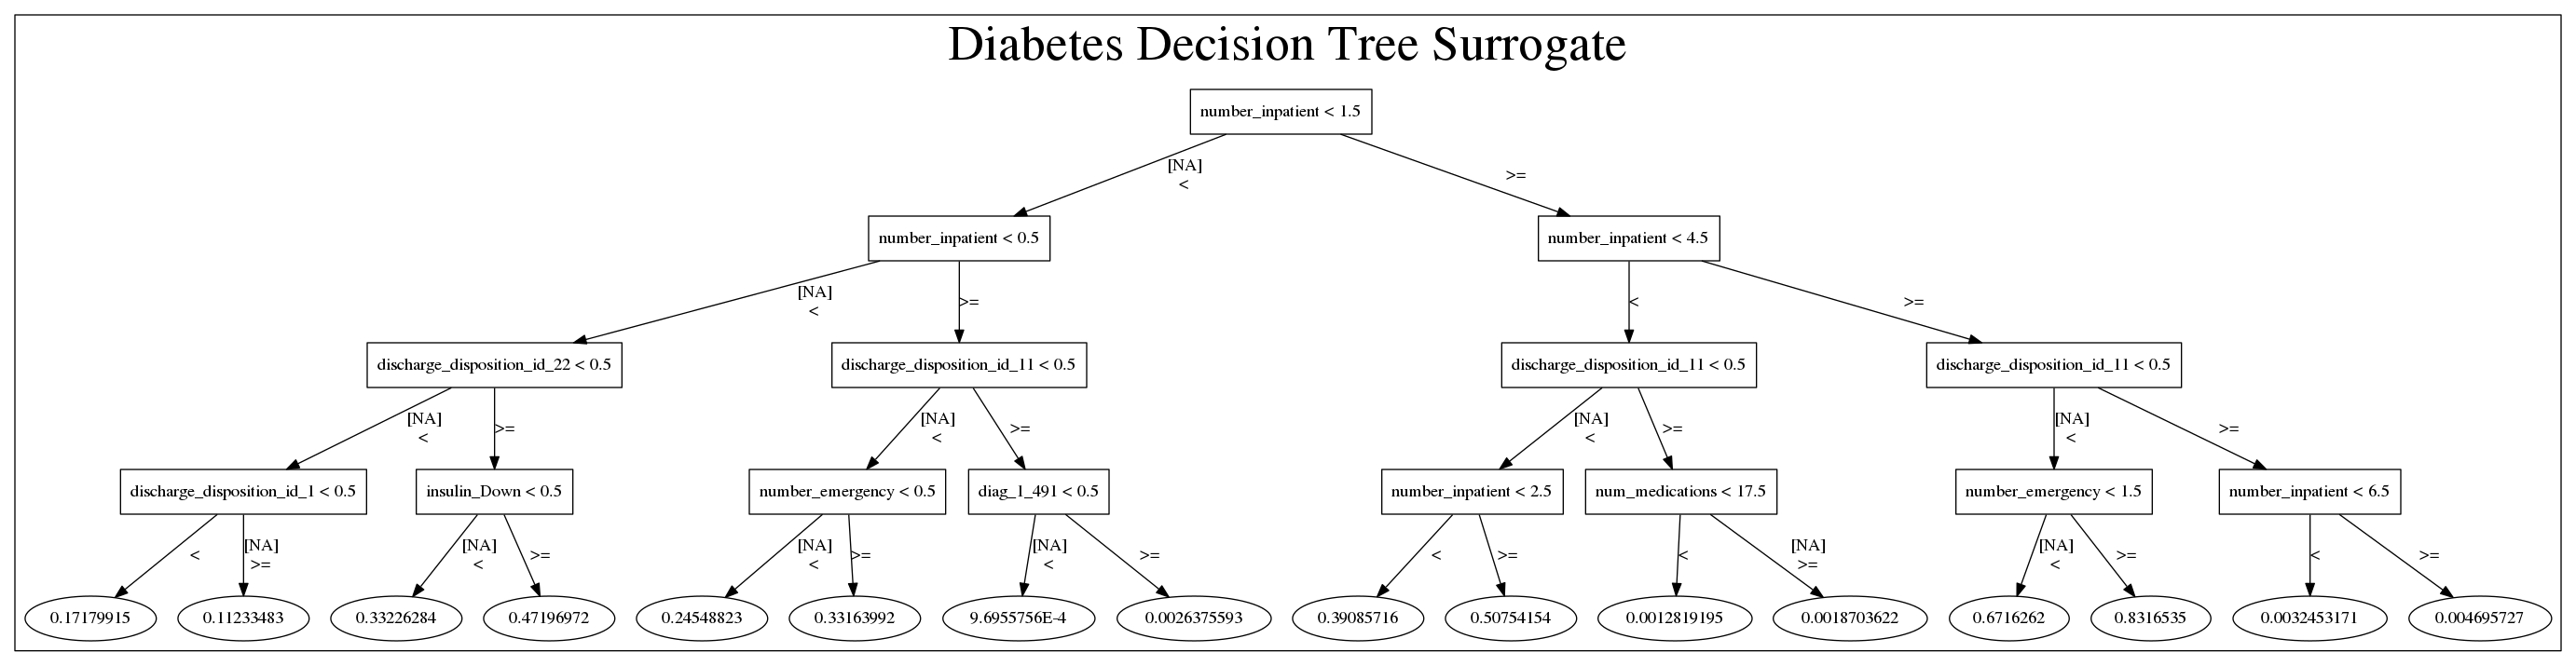

In [49]:
# display in-notebook
display(Image((png_file_name)))

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Utility function that displays the Shapley results at the choosen decile

In [50]:
def shapley(row):
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(224, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.iloc[-5:,:].plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

##  10th decile of model predictions

In [51]:
decile = 10
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

                                              Approximate Local Contributions
number_inpatient                                                    -0.398597
number_diagnoses                                                    -0.199139
discharge_disposition_id_1                                          -0.153255
num_procedures                                                      -0.090443
diag_3_272                                                          -0.088852
num_lab_procedures                                                  -0.085059
time_in_hospital                                                    -0.079324
payer_code_q                                                        -0.066458
num_medications                                                     -0.066436
admission_source_id_7                                               -0.052398
number_emergency                                                    -0.046232
insulin_Steady                                                  

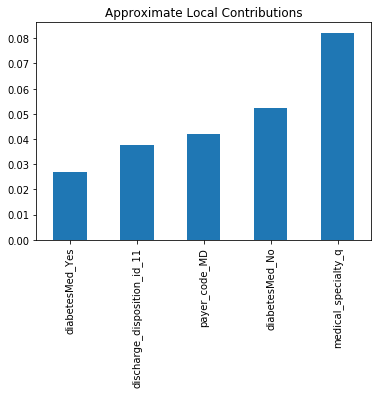

In [52]:
shapley(row)

In [53]:
row

,id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,acetohexamide,examide,citoglipton,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmitted,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_metformin_No,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,change_Ch,change_No,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,tolbutamide_No,tolbutamide_Steady,chlorpropamide_No,chlorpropamide_Steady,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,tolazamide_No,gender_Female,gender_Male,gender_Unknown_Invalid,acarbose_No,acarbose_Steady,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glyburide_metformin_No,glyburide_metformin_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,miglitol_Down,miglitol_No,miglitol_Steady,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,troglitazone_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,ID,predict
16202,443778398,134647673,1,1,5,8,0,0,0,4,No,No,No,No,No,No,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,

##  Median of predictions

In [54]:
decile = 50
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

                                              Approximate Local Contributions
number_inpatient                                                    -0.381863
discharge_disposition_id_1                                          -0.130846
payer_code_BC                                                       -0.098200
payer_code_q                                                        -0.093692
num_lab_procedures                                                  -0.070509
medical_specialty_q                                                 -0.056294
admission_source_id_7                                               -0.049173
diag_3_401                                                          -0.044966
time_in_hospital                                                    -0.027759
admission_type_id_2                                                 -0.025942
discharge_disposition_id_22                                         -0.023738
diag_1_428                                                      

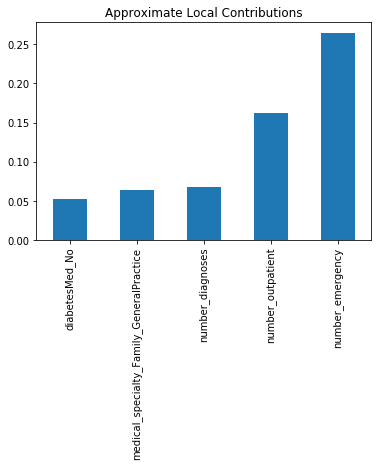

In [55]:
shapley(row)

In [56]:
row

,id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,acetohexamide,examide,citoglipton,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmitted,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_metformin_No,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,change_Ch,change_No,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,tolbutamide_No,tolbutamide_Steady,chlorpropamide_No,chlorpropamide_Steady,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,tolazamide_No,gender_Female,gender_Male,gender_Unknown_Invalid,acarbose_No,acarbose_Steady,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glyburide_metformin_No,glyburide_metformin_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,miglitol_Down,miglitol_No,miglitol_Steady,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,troglitazone_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,ID,predict
14401,411470570,43556985,3,1,0,13,1,1,0,8,No,No,No,No,No,No,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,

##  90th decile of model predictions

In [57]:
decile = 90
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

                                              Approximate Local Contributions
metformin_No                                                        -0.122164
discharge_disposition_id_1                                          -0.081790
age_50_60_                                                          -0.069280
metformin_Steady                                                    -0.067079
payer_code_q                                                        -0.066154
number_emergency                                                    -0.042345
number_outpatient                                                   -0.033574
discharge_disposition_id_22                                         -0.032414
admission_type_id_2                                                 -0.025852
diag_1_428                                                          -0.021082
admission_type_id_6                                                 -0.017825
discharge_disposition_id_3                                      

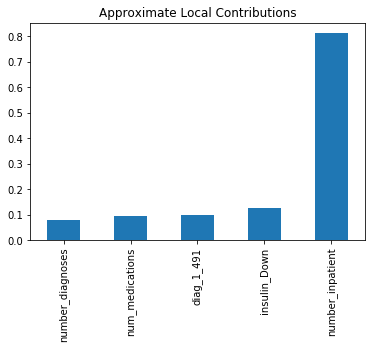

In [58]:
shapley(row) # <- model is def wrong for this person

In [59]:
row

,id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,acetohexamide,examide,citoglipton,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmitted,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_metformin_No,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,discharge_disposition_id_1,discharge_disposition_id_2,discharge_disposition_id_3,discharge_disposition_id_4,discharge_disposition_id_5,discharge_disposition_id_6,discharge_disposition_id_7,discharge_disposition_id_11,discharge_disposition_id_13,discharge_disposition_id_14,discharge_disposition_id_18,discharge_disposition_id_22,discharge_disposition_id_23,discharge_disposition_id_25,discharge_disposition_id_Other,change_Ch,change_No,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,tolbutamide_No,tolbutamide_Steady,chlorpropamide_No,chlorpropamide_Steady,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,tolazamide_No,gender_Female,gender_Male,gender_Unknown_Invalid,acarbose_No,acarbose_Steady,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,admission_source_id_1,admission_source_id_2,admission_source_id_3,admission_source_id_4,admission_source_id_5,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_14,admission_source_id_17,admission_source_id_22,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,glyburide_metformin_No,glyburide_metformin_Steady,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,medical_specialty_q,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,miglitol_Down,miglitol_No,miglitol_Steady,payer_code_q,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,race_q,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,admission_type_id_1,admission_type_id_2,admission_type_id_3,admission_type_id_4,admission_type_id_5,admission_type_id_6,admission_type_id_7,admission_type_id_8,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,troglitazone_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_q,diag_3_Other,diag_3_V45,weight_q,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,ID,predict
5538,277554402,45659178,10,42,1,34,0,0,2,9,No,No,No,No,No,No,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0

In [60]:
h2o.cluster().shutdown()

H2O session _sid_b18e closed.
